In [10]:
import subprocess
import sys
sys.path.insert(0,'..')
from pathlib import Path
import os
import warnings

import random
import numpy as np
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import joblib
from textwrap import dedent
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE

from focal_loss import FocalLoss

import torch
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package],
                         stdout=subprocess.DEVNULL,
                         stderr=subprocess.DEVNULL
                         )
required_packages = [
    "torchsummary",
]
for package in required_packages:
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        install(package)
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler

torchsummary is already installed.


## Flags and Variables

In [11]:
# set paths

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    # Kaggle environment
    root_dir = '/kaggle/input/pre-processed-data'
elif 'COLAB_GPU' in os.environ:
    # Google Colab environment
    root_dir = '/content/drive/MyDrive/your-dataset-directory'
else:
    # Local environment
    root_dir = r'C:\Users\Khizer Zakir\OneDrive - Université Bretagne Sud\thesis\Covariance_Thesis\notebooks\npz_data_preprocessed'
npz_file = "data_preprocessed.npz"

file_path = os.path.join(root_dir, npz_file)

model_name = "MLP"   # Change to "MLP", "LSTM", or "CNN" as needed
# for model_name in ["MLP", "LSTM", "CNN"]:
#     folder_name = f"{model_name}_FR"
#     os.makedirs(folder_name, exist_ok=True)
#     print(f"Folder '{folder_name}' created or already exists.")
    
# os.makedirs(folder_name, exist_ok=True)
batch_size = 64  # batch size
n_classes = 11
dropout_rate = 0
random_seed = 42
test_size = 0.2
val_size = 0.5
val = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

figure_name = f"CM_{model_name}"
plot_figure_name = f"training_validation_results_{model_name}"

# for model
lr=1e-2
epochs=200
gamma_value=0.95
loss = "focal"
gamma_loss = 3
step_size=30
step_lr = False

## Model and Dataset definition

In [12]:
class TimeSeriesMLP(nn.Module):

    def __init__(self, input_size, output_size, hidden_units=[128, 256, 128], dropout_rate=None):
        super(TimeSeriesMLP, self).__init__()

        self.fc_in = nn.Linear(input_size, hidden_units[0])
        fc_modules = []

        for i in range(len(hidden_units)-1):
            fc_modules.append(nn.Linear(hidden_units[i], hidden_units[i+1]))
            fc_modules.append(nn.ReLU())

            if dropout_rate is not None:
                fc_modules.append(nn.Dropout(dropout_rate))  # Add dropout after ReLU

        self.fc_hidden = nn.Sequential(*fc_modules)
        self.fc_out = nn.Linear(hidden_units[-1], output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc_in(x))
        x = self.fc_hidden(x)
        x = self.softmax(self.fc_out(x))
        return x


In [13]:
class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(TimeSeriesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.softmax(self.fc(x[:, -1, :]))  # Use the last time step's output for prediction
        return x

In [14]:

# class CNN1D(nn.Module):
#     def __init__(self, input_channels, num_classes, kernel_size=3, dropout_prob=0):
#         super(CNN1D, self).__init__()
#         self.conv_block1 = self.create_conv_block(input_channels, 32, kernel_size, dropout_prob)
#         self.conv_block2 = self.create_conv_block(32, 64, kernel_size, dropout_prob)
#         self.conv_block3 = self.create_conv_block(64, 128, kernel_size, dropout_prob)
#         self.fc1 = nn.Linear(128 * 1, 64)
#         self.fc2 = nn.Linear(64, num_classes)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropout_prob)
#         self.softmax =  nn.Softmax(dim=1)

#     def create_conv_block(self, in_channels, out_channels, kernel_size, dropout_prob):
#         return nn.Sequential(
#             nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
#             nn.BatchNorm1d(out_channels),
#             nn.ReLU(),
#             nn.Dropout(dropout_prob),
#             nn.MaxPool1d(kernel_size=3)
#         )

#     def forward(self, x):
#         x = x.permute(0, 2, 1)
#         x = self.conv_block1(x)
#         x = self.conv_block2(x)
#         x = self.conv_block3(x)
#         x = x.view(x.size(0), -1)  # Flatten the tensor
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.softmax(self.fc2(x))
#         return x
    
import torch
import torch.nn as nn

class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes, sequence_length):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
        # Compute the flattened size for the first fully connected layer
        self._flattened_size = self._calculate_flattened_size(sequence_length)
        
        self.fc1 = nn.Linear(self._flattened_size, 32) 
        self.fc2 = nn.Linear(32, num_classes)

    def _calculate_flattened_size(self, sequence_length):
        # Compute the size of the tensor after conv1, conv2, and pooling
        x = torch.zeros(1, sequence_length, 1)  # Simulated input tensor
        x = x.permute(0, 2, 1)  # Change to (batch, channels, sequence)
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        return x.numel()  # Total flattened size

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Permute to [m, feature, sequence] for Conv1d
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))  # Using softmax for multiclass classification
        return x


In [15]:
# dataset and transforms

class NormalizeTransform:
    def __init__(self, data):
        self.percentile_98 = np.percentile(data, 98)
        # make it torch tensor
        self.percentile_98 = torch.tensor(self.percentile_98, dtype=torch.float32)
    def __call__(self, sample):
        return sample / self.percentile_98

class data_CNN(Dataset):
    def __init__(self, root_dir, npz_file, transform=None):
        self.root_dir = root_dir
        self.npz_file = npz_file
        self.x, self.y, self.class_names = self.load_data()
        
        if transform is None:
            self.transform = NormalizeTransform(self.x)
        else:
            self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        sample = self.x[idx]
        sample = torch.tensor(sample, dtype=torch.float32)
        label = self.y[idx]
        label = torch.tensor(label, dtype=torch.uint8)
        class_name = self.class_names[label]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample, label

    def load_data(self):
        file_path = os.path.join(self.root_dir, self.npz_file)
        data = np.load(file_path, allow_pickle=True)
        x = data['series']
        y = data['labels']
        class_names = data['class_names']
        return x, y, class_names

## Helper functions

In [16]:
def initialize_model(model_name, input_size, n_classes=None, hidden_units=None, hidden_size=None, num_layers=1, dropout_rate=None):
    if model_name == "TimeSeriesMLP":
        if hidden_units is None:
            hidden_units = [128, 256, 128]
        model = TimeSeriesMLP(input_size=input_size, output_size=n_classes, hidden_units=hidden_units, dropout_rate=dropout_rate)
        print("TimeSeriesMLP model initialized")

    elif model_name == "TimeSeriesLSTM":
        if hidden_size is None:
            hidden_size = 128
        model = TimeSeriesLSTM(input_size=input_size, hidden_size=hidden_size, output_size=n_classes, num_layers=num_layers)
        print("TimeSeriesLSTM model initialized")

    elif model_name == "CNN1D":
        if n_classes is None:
            raise ValueError("Number of classes (n_classes) must be specified for CNN1D.")
#         model = CNN1D(input_channels=input_size, num_classes=n_classes, dropout_prob=dropout_rate)
        model = CNN1D(input_size, n_classes)
        print(model)
        print("CNN1D model initialized")

    else:
        raise ValueError(f"Model {model_name} not found")

    # Print trainable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total trainable parameters: {total_params}')
    
    return model


# calculate the weights for the classes
def calculate_class_weights(labels):
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
    weight = 1 - class_sample_count / len(labels)
    return torch.from_numpy(weight).double()
# data loaders
def create_data_loaders(dataset, train_indices, val_indices, test_indices, batch_size, val=True):
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_indices), shuffle=False)
    
    if val:
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
        return train_loader, val_loader, test_loader
    else:
        return train_loader, test_loader
    
# plotting data distribution
def plot_class_distribution(train_loader, val_loader, test_loader, n_classes):

    class_names = train_loader.dataset.class_names
    
    def count_labels(loader, n_classes):
        counts = np.zeros(n_classes)
        for _, labels in loader:
            for l in labels:
                counts[l] += 1
        return counts

    train_counts = count_labels(train_loader, n_classes)
    
    if val_loader is not None:
        val_counts = count_labels(val_loader, n_classes)
    else:
        val_counts = np.zeros(n_classes)
    
    test_counts = count_labels(test_loader, n_classes)

    # Bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(n_classes) - test_size, train_counts, 0.2, label='Train')
    if val_loader is not None:
        plt.bar(np.arange(n_classes), val_counts, 0.2, label='Validation')
    plt.bar(np.arange(n_classes) + 0.2, test_counts, 0.2, label='Test')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.yscale('log')
    if val_loader is not None:
        plt.title('Class Distribution in Train, Validation, and Test Sets')
    else:
        plt.title('Class Distribution in Train and Test Sets')
    plt.xticks(np.arange(n_classes), class_names, rotation=45)
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(n_classes), train_counts, alpha=0.5, label='Train')
    plt.bar(np.arange(n_classes), val_counts, alpha=0.5, label='Validation')
    plt.bar(np.arange(n_classes), test_counts, alpha=0.5, label='Test')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.yscale('log')
    if val_loader is not None:
        plt.title('Histogram of Class Distribution in Train, Validation, and Test Sets')
    else:
        plt.title('Histogram of Class Distribution in Train and Test Sets')
    plt.xticks(np.arange(n_classes), class_names, rotation=45)
    plt.legend(loc='best')
    plt.show()

In [17]:

def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    loss_train, acc_train = [], []
    
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device).long()
        optimizer.zero_grad()
        # Forward pass
        out = model(x)
        l = loss_fn(out, y)
        
        acc, loss = (out.argmax(1) == y).cpu().numpy().sum() / out.shape[0], l.cpu().data.numpy()
        loss_train.append(loss)
        acc_train.append(acc)
        l.backward()
        optimizer.step()

    acc_train = np.asarray(acc_train).mean()
    loss_train = np.asarray(loss_train).mean()
    
    return loss_train, acc_train

def validate_one_epoch(model, val_loader, loss_fn, device):
    model.eval()
    loss_val, acc_val_list = [], []
    y_true, y_pred = [], []

    for x,y in val_loader:
        x = x.to(device)
        y = y.to(device).long()
        
        with torch.no_grad():
            # Forward pass
            out = model(x)
            l = loss_fn(out, y)
        
        loss_val.append(l.cpu().data.numpy())
        predicted_labels = out.argmax(1)
        y_true.extend(list(y.cpu().numpy()))
        y_pred.extend(list(predicted_labels.cpu().numpy()))
        acc = (predicted_labels == y).cpu().numpy().sum() / out.shape[0]
        acc_val_list.append(acc)
    
    acc_val = np.asarray(acc_val_list).mean()
    loss_val = np.asarray(loss_val).mean()
    f1_test = f1_score(y_true, y_pred, average='macro')
    
    return loss_val, acc_val, f1_test, y_true, y_pred

def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, epochs, folder_name):
    t1, t2, t3, t4, t5 = [], [], [], [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    min_val_loss = float('inf')
    best_epoch = 0

    for epoch in range(epochs):
        start_time = time.time()  # Start time of the epoch

        # Training phase
        loss_train, acc_train = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        scheduler.step()

        t1.append(loss_train)
        t2.append(100 * acc_train)

        # Validation phase
        loss_val, acc_val, f1_test, y_true, y_pred = validate_one_epoch(model, val_loader, loss_fn, device)

       
        t3.append(loss_val)
        t4.append(100 * acc_val)
        t5.append(100 * f1_test)
        
        print('Epoch {}/{} - Train loss: {:.4f} - Val loss: {:.4f} - Train acc: {:.2f}% - Val acc: {:.2f}% - Test F1-score: {:.2f}'.format(
            epoch + 1, epochs, loss_train, loss_val, 100 * acc_train, 100 * acc_val, 100 * f1_test))

        elapsed_time = time.time() - start_time
        print('Elapsed time: {:.2f} seconds'.format(elapsed_time))
        
        # Save the best model
        if loss_val < min_val_loss:
            min_val_loss = loss_val
            best_epoch = epoch + 1

            ckpt = {
                'epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                'train_loss_history': t1,
                'train_accuracy_history': t2,
                'val_loss_history': t3,
                'val_accuracy_history': t4,
                'y_true': y_true,
                'y_pred': y_pred,
                'loss': min_val_loss
            }
            
            best_model_path = os.path.join(folder_name, 'best_model.pth')
            torch.save(ckpt, best_model_path)
            print(f'Best model checkpoint saved at {best_model_path}')

    # Save training results to a CSV file
    results_df = pd.DataFrame({
        'epoch': np.arange(1, epochs + 1),
        'train_loss': t1,
        'train_acc': t2,
        'val_loss': t3,
        'val_acc': t4,
        'f1_score': t5

    })
    results_df.to_csv(os.path.join(folder_name, 'training_results.csv'), index=False)

    return t1, t2, t3, t4, t5, best_epoch, best_model_path

In [18]:

def plot_training_results(t1, t2, t3, t4, t5, folder_name, figure_name, best_epoch):
    print(f'Best epoch: {best_epoch}')
    plt.figure(figsize=(12, 8))
    plt.title("Training and Validation Loss and Accuracy")

    # Plot training and validation loss
    p1, = plt.plot(t1, label='Train loss', color='blue')
    p2, = plt.plot(t3, label='Validation loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 0.5)

    ax2 = plt.twinx()

    # Plot training and validation accuracy
    p3, = ax2.plot(t2, label='Train accuracy', color='orange')
    p4, = ax2.plot(t4, label='Validation accuracy', color='green')
    ax2.set_ylabel('Accuracy (%)')

    # Plot test F1-score
    p5, = ax2.plot(t5, label='F1-score-Validation', linestyle='dashed', color='purple')

    # Combine legends
    lines = [p1, p2, p3, p4, p5]
    labels = [line.get_label() for line in lines]
    plt.legend(lines, labels, loc='center left', bbox_to_anchor=(1.1, 0.5))

    # Save the figure with the provided name
    plot_name = os.path.join(folder_name, figure_name)
    plt.savefig(f'{plot_name}.png', bbox_inches='tight', pad_inches=0.2, dpi=500)
    print(f'Figure saved as {figure_name}.png')
    plt.show()

In [32]:

def evaluate_model(model, best_model_path, data_loader, loss_fn, model_name, figure_name, folder_name, device=device):

    # Load the best model
    # model = initialize_model(model_name, n_classes)
    model.to(device)
    ckpt = torch.load(best_model_path)
    model.load_state_dict(ckpt['model_state_dict'])
    epoch = ckpt['epoch']
    print(f'Model loaded from the best epoch {epoch}')
    print('Model loaded')
    
    loss_val, acc_val = [], []
    y_true, y_pred = [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device).long()
        
        with torch.no_grad():
            # Forward pass
            out = model(x)
            l = loss_fn(out, y)
        
        predicted_labels = out.argmax(1)
        y_true.extend(list(y.cpu().numpy()))
        y_pred.extend(list(predicted_labels.cpu().numpy()))
        acc = (predicted_labels == y).cpu().numpy().sum() / out.shape[0]
        loss_val.append(l.cpu().data.numpy())
        acc_val.append(acc)

    acc_val = np.asarray(acc_val).mean()
    loss_val = np.asarray(loss_val).mean()

    print('Validation loss: {:.4f}'.format(loss_val))
    print('Validation accuracy: {:.2f}%'.format(100 * acc_val))

    # Save the model
    model_filename = os.path.join(folder_name, f'{model_name}.ckpt')
    torch.save(model.state_dict(), model_filename)
    print(f'Model saved as {model_name}.ckpt')

    # Print and save classification report
    cf_report = classification_report(y_true, y_pred, digits=2, target_names=data_loader.dataset.class_names)
    print(cf_report)
    cf_report_filename = os.path.join(folder_name, f'{model_name}_classification_report.txt')
    with open(cf_report_filename, 'w') as f:
        f.write(cf_report)
    print(f'Classification report saved as {cf_report_filename}')

    # Compute and plot confusion matrix
    cmatrix = confusion_matrix(y_true, y_pred)
    Ncmatrix = cmatrix.astype('float') / cmatrix.sum(axis=1)[:, np.newaxis]

    group_counts = ['{0:0.0f}'.format(value) for value in cmatrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in Ncmatrix.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(len(data_loader.dataset.class_names), len(data_loader.dataset.class_names))

    # Plot and save the confusion matrix figure
    plt.figure(figsize=(10, 8))
    sns.heatmap(Ncmatrix, annot=labels, fmt='', cmap='Reds', xticklabels=data_loader.dataset.class_names, yticklabels=data_loader.dataset.class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Acc={:.2f}%'.format(100 * acc_val))
    
    plot_name = os.path.join(folder_name, f'{figure_name}.png')
    plt.savefig(plot_name, bbox_inches='tight', pad_inches=0.2, dpi=500)
    plt.show()
    print(f'Figure saved as {figure_name}.png')

    return 100 * acc_val

Class weights: tensor([0.8200, 0.9956, 0.5045, 0.9963, 0.9974, 0.9880, 0.9615, 0.9959, 0.9641,
        0.9747, 0.8020], device='cuda:0', dtype=torch.float64)


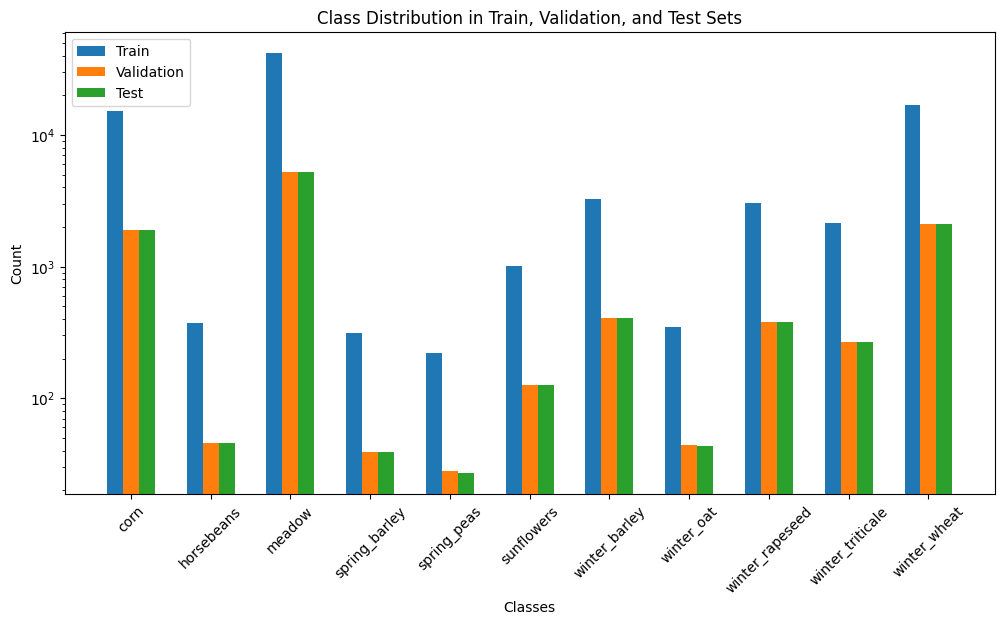

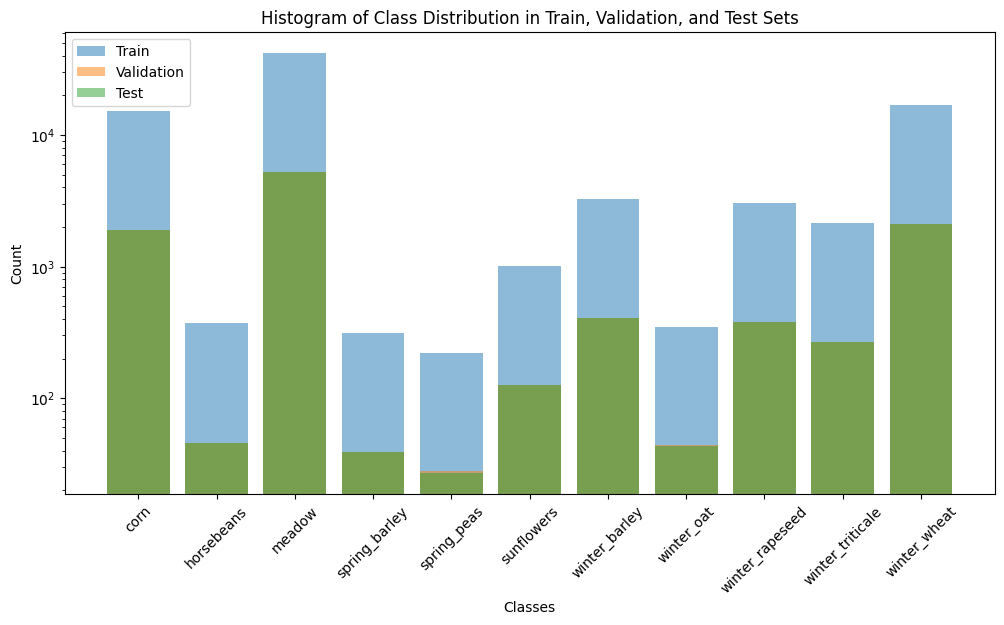

In [20]:
%matplotlib inline
dataset = data_CNN(root_dir, npz_file)

# Split data into train, validation, and test sets
if val is not None:
    train_indices, test_indices = train_test_split(list(range(len(dataset))),
                                                    test_size=test_size, stratify=dataset.y, random_state=random_seed)
    test_indices, val_indices = train_test_split(test_indices,
                                                   test_size=val_size, stratify=dataset.y[test_indices], random_state=random_seed)
else:
    train_indices, test_indices = train_test_split(list(range(len(dataset))),
                                                   test_size=test_size, stratify=dataset.y, random_state=random_seed)
    val_indices = None

# Calculate class weights
weights = calculate_class_weights(dataset.y)
weights = weights.to(device)
print(f"Class weights: {weights}")

# Create data loaders
if val:
    train_loader, val_loader, test_loader = create_data_loaders(dataset, train_indices, val_indices, test_indices, batch_size, val=val)
else:
    train_loader, test_loader = create_data_loaders(dataset, train_indices, val_indices, test_indices, batch_size, val=val)
    val_loader = None

# Plot class distribution
plot_class_distribution(train_loader, val_loader, test_loader, n_classes=n_classes)

In [21]:
for x, y in train_loader:
    print(x)
    print(x.shape)
    print(y.shape)
    break

tensor([[[0.2539, 0.2121, 0.1972,  ..., 0.3804, 0.2541, 0.1796],
         [0.7728, 0.7165, 0.7615,  ..., 0.8316, 0.4842, 0.3334],
         [0.3293, 0.2874, 0.2930,  ..., 0.4388, 0.3606, 0.2897],
         ...,
         [0.1489, 0.1332, 0.0922,  ..., 0.4442, 0.2366, 0.1172],
         [0.1582, 0.1358, 0.1028,  ..., 0.4215, 0.2019, 0.0947],
         [0.6280, 0.5647, 0.5923,  ..., 0.6717, 0.4562, 0.2923]],

        [[0.1695, 0.1373, 0.0929,  ..., 0.4979, 0.2193, 0.1169],
         [0.2150, 0.1850, 0.1551,  ..., 0.4019, 0.1666, 0.1032],
         [0.1413, 0.1246, 0.0806,  ..., 0.5147, 0.1957, 0.0921],
         ...,
         [0.1470, 0.1300, 0.0809,  ..., 0.4977, 0.2211, 0.1072],
         [0.1989, 0.1636, 0.1347,  ..., 0.3890, 0.1748, 0.1100],
         [0.3085, 0.2695, 0.2636,  ..., 0.4533, 0.3578, 0.2996]],

        [[0.1911, 0.1496, 0.1390,  ..., 0.2236, 0.1951, 0.1453],
         [0.1561, 0.1289, 0.1236,  ..., 0.2288, 0.2379, 0.1407],
         [0.1490, 0.1214, 0.1189,  ..., 0.2315, 0.2354, 0.

In [27]:

if model_name == "MLP":
    folder_name = "MLP_FR"
    os.makedirs(folder_name, exist_ok=True)
    model = initialize_model(
        model_name="TimeSeriesMLP",
        input_size=360,          # 36 time steps
        n_classes=n_classes,  # 10 classes
        hidden_units=[64, 128], # Example hidden layer sizes
        dropout_rate=dropout_rate
    )
    model.to(device)
    print("Initialized TimeSeriesMLP")


elif model_name == "LSTM":
    folder_name = "LSTM_FR"
    os.makedirs(folder_name, exist_ok=True)
    model = initialize_model(
        model_name="TimeSeriesLSTM",
        input_size=36,          # 36 features (time steps)
        n_classes=n_classes,  # 10 classes
        hidden_size=64,         # Example hidden size
        num_layers=2            # Example number of LSTM layers
    )
    model.to(device)
    print("Initialized TimeSeriesLSTM")

elif model_name == "CNN":
    folder_name = "CNN_FR"
    os.makedirs(folder_name, exist_ok=True)
    model = initialize_model(
        model_name="CNN1D",
        input_size=10,          # 36 features (input channels)
        n_classes=n_classes,    # 10 classes
#         dropout_rate=dropout_rate        # Example dropout rate
    )
    model.to(device)
    print("Initialized CNN1D")

else:
    raise ValueError(f"Model {model_name} not recognized")


TimeSeriesMLP model initialized
Total trainable parameters: 32843
Initialized TimeSeriesMLP


In [28]:
if loss == "focal":
    loss_fn = FocalLoss(gamma=gamma_loss,weights=weights)
else:
    loss_fn = nn.CrossEntropyLoss(weights=weights)
#opti = MixOptimizer(model.parameters(),lr=lr)
opti = optim.Adam(model.parameters(), lr=lr)
if step_lr:
    scheduler = lr_scheduler.StepLR(opti, step_size, gamma_value)
else:
    scheduler = lr_scheduler.ExponentialLR(opti, gamma=gamma_value)

In [29]:
%matplotlib inline

if val:
    t1, t2, t3, t4, t5, best_epoch, best_model_path = train_model(model, train_loader, val_loader, loss_fn, opti, scheduler, epochs, folder_name)
else:
    t1, t2, t3, t4, t5, best_epoch, best_model_path = train_model(model, train_loader, test_loader, loss_fn, opti, scheduler, epochs, folder_name)

Epoch 1/200 - Train loss: 0.2790 - Val loss: 0.1760 - Train acc: 84.38% - Val acc: 88.73% - Test F1-score: 45.06
Elapsed time: 6.48 seconds
Best model checkpoint saved at MLP_FR/best_model.pth
Epoch 2/200 - Train loss: 0.1713 - Val loss: 0.1364 - Train acc: 89.43% - Val acc: 89.10% - Test F1-score: 54.99
Elapsed time: 6.20 seconds
Best model checkpoint saved at MLP_FR/best_model.pth
Epoch 3/200 - Train loss: 0.1457 - Val loss: 0.2038 - Train acc: 90.79% - Val acc: 84.79% - Test F1-score: 48.18
Elapsed time: 6.22 seconds
Epoch 4/200 - Train loss: 0.1304 - Val loss: 0.1153 - Train acc: 91.79% - Val acc: 93.02% - Test F1-score: 58.93
Elapsed time: 6.32 seconds
Best model checkpoint saved at MLP_FR/best_model.pth
Epoch 5/200 - Train loss: 0.1224 - Val loss: 0.1051 - Train acc: 92.33% - Val acc: 92.87% - Test F1-score: 59.25
Elapsed time: 6.06 seconds
Best model checkpoint saved at MLP_FR/best_model.pth
Epoch 6/200 - Train loss: 0.1181 - Val loss: 0.1487 - Train acc: 92.44% - Val acc: 92.19

Best epoch: 93
Figure saved as training_validation_results_MLP.png


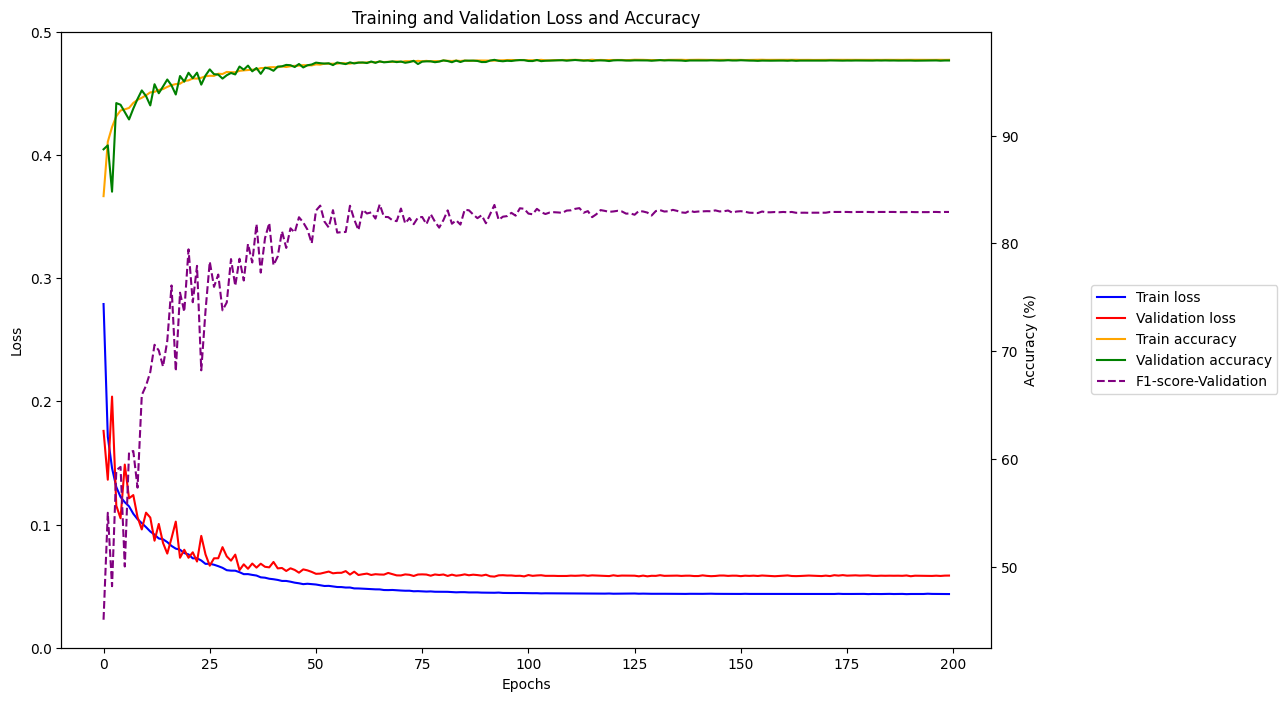

In [30]:

plot_training_results(t1, t2, t3, t4, t5,folder_name, plot_figure_name, best_epoch)

/tmp/ipykernel_36/3739023269.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_model_path)


Model loaded from the best epoch 93
Model loaded
Validation loss: 0.0602
Validation accuracy: 96.70%
Model saved as MLP.ckpt
                  precision    recall  f1-score   support

            corn       0.98      0.98      0.98      1909
      horsebeans       0.89      0.74      0.81        46
          meadow       0.99      0.99      0.99      5254
   spring_barley       0.76      0.67      0.71        39
     spring_peas       0.78      0.67      0.72        27
      sunflowers       0.85      0.87      0.86       127
   winter_barley       0.91      0.92      0.92       409
      winter_oat       0.73      0.19      0.30        43
 winter_rapeseed       0.98      0.97      0.97       381
winter_triticale       0.73      0.67      0.70       269
    winter_wheat       0.95      0.97      0.96      2099

        accuracy                           0.97     10603
       macro avg       0.87      0.79      0.81     10603
    weighted avg       0.97      0.97      0.97     10603

Cl

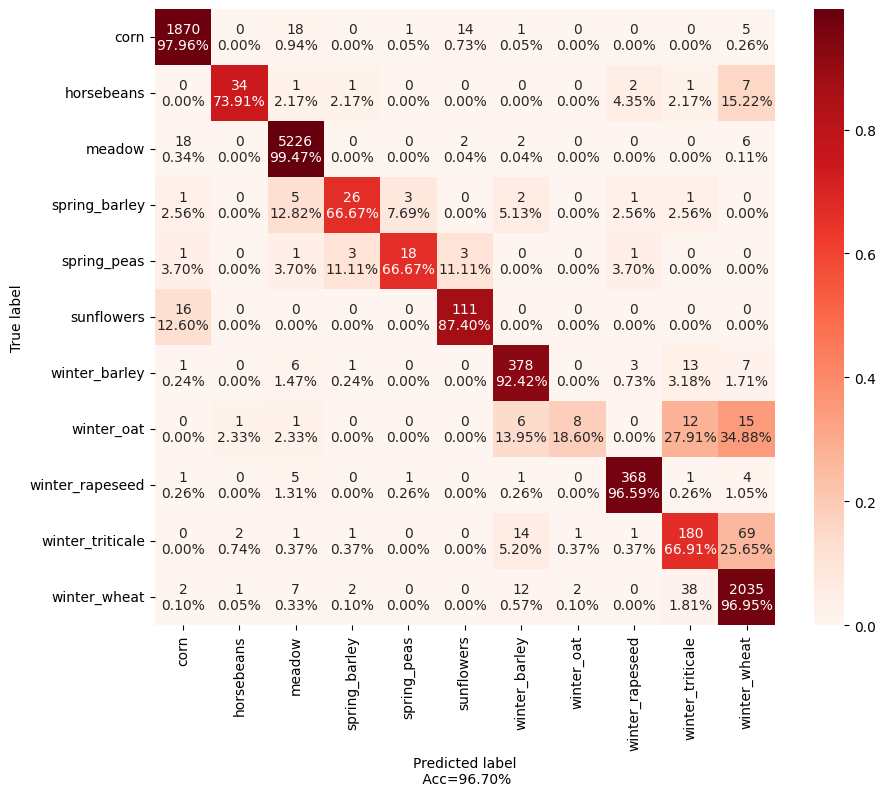

Figure saved as CM_MLP.png


In [33]:
%matplotlib inline
acc_val = evaluate_model(model, best_model_path, test_loader, loss_fn, model_name, figure_name, folder_name, device=device)